# WhisperX Transcription

This notebook demonstrates how to transcribe audio using the `whisperx` model. We will:
1. Load and preprocess an audio file.
2. Apply the WhisperX model to transcribe the audio.
3. Output the transcription.

## Explanation
The WhisperX model is a state-of-the-art speech recognition model that can transcribe audio into text. It is particularly useful for converting spoken language into written text, which can be used for various applications such as subtitles, transcription services, and more.


## Step 1: Install Requirements

In [1]:
# Setup installers
commands = [
    ("PIP_ROOT_USER_ACTION=ignore pip install -q numpy", "Install numpy"),
    ("PIP_ROOT_USER_ACTION=ignore pip install -q soundfile", "Install soundfile"),
    ("PIP_ROOT_USER_ACTION=ignore pip install -q tqdm", "Install tqdm"),
    ("PIP_ROOT_USER_ACTION=ignore pip install -q -U git+https://github.com/m-bain/whisperx.git", "Install WhisperX")
]

# Import the utils module which sets up the environment
from modules import utils
from modules import disable_warnings

# Use LogTools
log_tools = utils.LogTools()

# Execute
log_tools.command_state(commands)

Running Klingon Tools Installer...                                      OK
Running Disable Warnings...                                             OK
Running Install numpy...                                                OK
Running Install soundfile...                                            OK
Running Install tqdm...                                                 OK
Running Install WhisperX...                                             OK


## Step 2: Load Libraries

In [2]:
print("Loading libraries...")
# Import necessary libraries
from tqdm import tqdm
import gc
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import subprocess
import threading
import time
import torch
import whisperx

# Check to see what GPU resources are available
print("\nChecking GPU resources...")
def get_best_device():
    if torch.cuda.is_available():
        print("Using CUDA")
        return torch.device("cuda"), "cuda"
    elif torch.backends.mps.is_available():
        print("Using MPS")
        return torch.device("mps"), "mps"
    else:
        print("Using CPU")
        return torch.device("cpu"), "cpu"

device, device_name = get_best_device()

Loading libraries...

Checking GPU resources...
Using CUDA


## Step 3: Load the Audio File

We start by loading an audio file using `soundfile`. The audio needs to be in a
format supported by `whisperx`.

Audio sample rate: 8000 Hz
Audio duration: 87.55 seconds


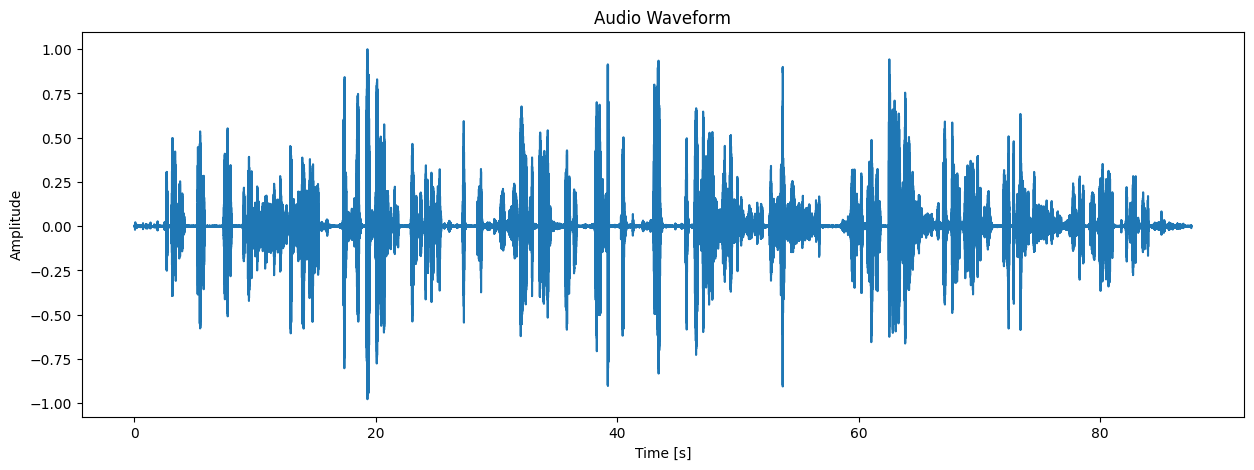

In [3]:
# Load the audio file
audio_filepath = "../../test_pcm.wav"
audio, sample_rate = sf.read(audio_filepath)

# Display the audio properties
print(f"Audio sample rate: {sample_rate} Hz")
print(f"Audio duration: {len(audio) / sample_rate:.2f} seconds")

# Plot the audio waveform
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.title('Audio Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

# Listen to the audio from the in memory data
ipd.Audio(audio, rate=sample_rate)

## Step 4: Transcribe the Audio

Next, we apply the WhisperX model to transcribe the audio file.

### Model Options
The WhisperX model comes in several sizes, each with different performance characteristics:
- `tiny`
- `tiny.en`
- `base`
- `base.en`
- `small`
- `small.en`
- `medium`
- `medium.en`
- `large`
- `large-v2`
- `large-v3`


In [4]:
# Set WhisperX variables
model_name = "large-v3"
batch_size = 16  # reduce if low on GPU mem
compute_type = "float16"  # change to "int8" if low on GPU mem (may reduce accuracy)

# Function to update transcription progress
def update_progress_bar(progress_bar, duration, interval=1):
    for i in range(0, duration, interval):
        time.sleep(interval)
        progress_bar.update(interval)
    progress_bar.update(duration % interval)

# Function to display model loading progress and handle checkpoint upgrade
def load_model_with_progress(model_name, device_name, compute_type):
    print(f"Loading WhisperX {model_name} model...")
    progress_bar = tqdm(total=100, desc="Model Loading", bar_format="{l_bar}{bar:50}| {n_fmt}/{total_fmt} {elapsed}")

    try:
        # Load the WhisperX model
        model = whisperx.load_model(model_name, device_name, compute_type=compute_type)
    except RuntimeError as e:
        error_message = str(e)
        if "Lightning automatically upgraded your loaded checkpoint" in error_message:
            # Extract the command to run from the error message
            start_index = error_message.find("`python")
            end_index = error_message.find("`", start_index + 1)
            command_to_run = error_message[start_index + 1:end_index]
            
            # Run the upgrade command
            subprocess.run(command_to_run, shell=True, check=True)
            
            # Retry loading the model
            model = whisperx.load_model(model_name, device_name, compute_type=compute_type)
    
    for i in range(100):
        time.sleep(0.1)
        progress_bar.update(1)
    progress_bar.close()
    return model

# Load the WhisperX model with progress
device_name = "cuda"  # assuming you're using a GPU, change as needed

# Load the audio file
audio_filepath = "../../test_pcm.wav"
audio, sample_rate = sf.read(audio_filepath)

# Ensure audio is of type float32
audio = audio.astype(np.float32)

model = load_model_with_progress(model_name, device_name, compute_type)

# Create a progress bar for transcription
duration = int(len(audio) / sample_rate)
progress_bar = tqdm(total=duration, desc="Transcribing audio", bar_format="{l_bar}{bar:50}| {n_fmt}/{total_fmt} {elapsed}")

# Transcribe the audio
print("Starting transcription...")
result = model.transcribe(audio)  # Pass numpy array directly

# Start the progress update in a separate thread
progress_thread = threading.Thread(target=update_progress_bar, args=(progress_bar, duration))
progress_thread.start()

# Wait for the progress thread to finish and close the progress bar
progress_thread.join()
progress_bar.close()

# Output the transcription
# Raw output for debugging purposes
print("\nRAW OUTPUT:\n")
print(result)

# Get language
language = result['language']

# Sort segments by start time and get transcript
segments = result['segments']
segments_sorted = sorted(segments, key=lambda x: x['start'])
transcript = " ".join([segment['text'] for segment in segments_sorted])
print("\nTranscript:")
print(transcript)

Loading WhisperX large-v3 model...


Model Loading:   0%|                                                  | 0/100 00:00

No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.1.2+cu121. Bad things might happen unless you revert torch to 1.x.


Model Loading: 100%|██████████████████████████████████████████████████| 100/100 00:12
Transcribing audio:   0%|                                                  | 0/87 00:00

Starting transcription...
Detected language: en (0.90) in first 30s of audio...


Transcribing audio: 100%|██████████████████████████████████████████████████| 87/87 01:28


RAW OUTPUT:

{'segments': [{'text': ' Just for the sake of isolating my machine and agapping it rather than trying to connect it to the network and then just jump into it, am I able to get you to take me out to a fun shake over at the training camp?', 'start': 2.21, 'end': 29.155}, {'text': ' Thank you.', 'start': 29.155, 'end': 43.78}], 'language': 'en'}

Transcript:
 Just for the sake of isolating my machine and agapping it rather than trying to connect it to the network and then just jump into it, am I able to get you to take me out to a fun shake over at the training camp?  Thank you.


# Free up Resources
*Remove any local files and free up GPU resources.*

Press the large red button below to get started! 🚀

In [5]:
# Releasing cpu, gpu and memory resources
release_resources()

NameError: name 'release_resources' is not defined

In [6]:
# Free up resources
@LogTools.method_state(name="Running garbage collection")
def garbage_collection():
    # Run a general garbage collection
    print("")
    gc.collect()

@LogTools.method_state(name="Deleting model to free up memory")
def delete_model():
    # Delete the model
    del model

@LogTools.method_state(name="Clearing GPU cache")
def empty_cache():
    # Free up GPU memory
    torch.cuda.empty_cache()                                                                                                       

# Aggregate cleanup methods
def free_resources():
    garbage_collection()
    delete_model()
    empty_cache()

# Execute cleanup
LogTools.method_state(free_resources)

NameError: name 'LogTools' is not defined

## Conclusion

In this notebook, we demonstrated how to transcribe audio using `whisperx` models. We loaded and preprocessed the audio, applied the WhisperX model, and output the transcription.